# Variational Quantum Eigensolver - Ground State Energy for $H2$ Molecule using the UCCSD ansatz

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock, UCCSD, PUCCD

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

Backend

In [3]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for $H2$ molecule at equilibrium bond length 0.735 Angstrom

In [4]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [5]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [12]:
def initial_state_preparation(mapper_str: str = "pa"):
    
    molecule = "Li 0.0 0.0 0.0; H 0.0 0.0 1.5474"
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [13]:
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation("pa")

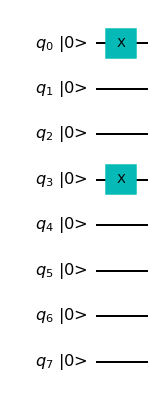

In [14]:
init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

init_state.draw("mpl", initial_state=True)

In [15]:
# Setting up TwoLocal for our ansatz
# ansatz_type = "RY"

# # Single qubit rotations that are placed on all qubits with independent parameters
# rotation_blocks = ["ry"]
# # Entangling gates
# entanglement_blocks = "cx"
# # How the qubits are entangled?
# entanglement = 'linear'
# # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
# repetitions = 1
# # Skipoing the final rotation_blocks layer
# skip_final_rotation_layer = False

# ansatz = TwoLocal(
#     qubit_op.num_qubits,
#     rotation_blocks,
#     entanglement_blocks,
#     reps=repetitions,
#     entanglement=entanglement,
#     skip_final_rotation_layer=skip_final_rotation_layer,
#     insert_barriers=True)

# # Add the initial state
# ansatz.compose(init_state, front=True, inplace=True)

In [16]:
ansatz_type = "UCCSD"

ansatz = UCCSD(
    qubit_converter=qubit_converter,
    num_particles=num_particles,
    num_spin_orbitals=num_spin_orbitals,
    reps=1,
    initial_state=init_state,
)

ansatz.compose(init_state, front=True, inplace=True)

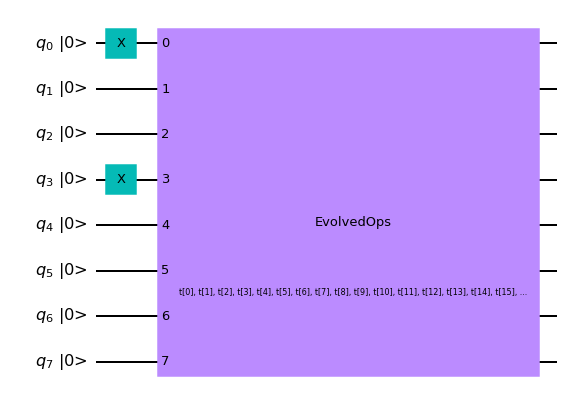

In [17]:
ansatz.draw(output="mpl", initial_state=True)

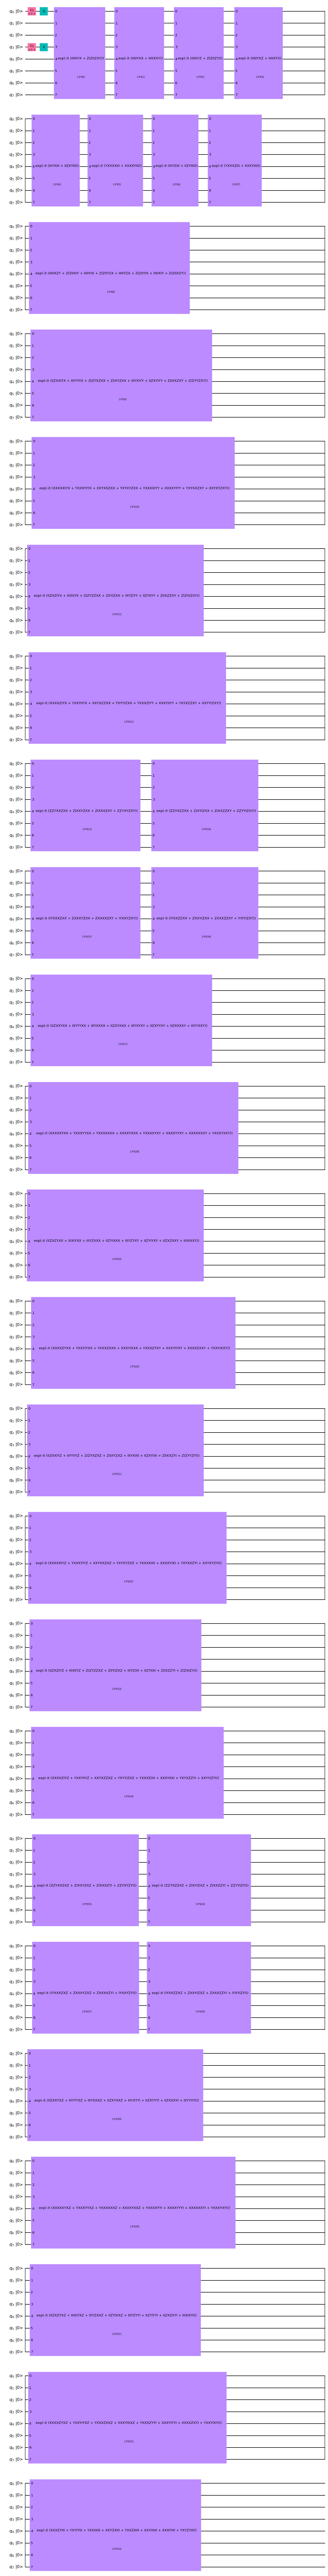

In [18]:
ansatz.decompose().draw(output="mpl", initial_state=True)

In [19]:
optimizer = COBYLA(maxiter=10000)

### Solver

Exact Eigensolver using NumPyMinimumEigensolver


In [20]:
result_exact = exact_diagonalizer(es_problem, qubit_converter)
exact_energy = np.real(result_exact.eigenenergies[0])

print("Exact Electronic Energy: {:.4f} Eh\n\n".format(exact_energy))

print("Results:\n\n", result_exact)

Exact Electronic Energy: -8.9087 Eh


Results:

 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.908697116424
  - computed part:      -8.908697116424
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.882762236781
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 


### VQE Solver

In [21]:
from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
    
quantum_instance = QuantumInstance(backend=state_sim)#Aer.get_backend("aer_simulator_statevector"))

vqe_solver = VQEUCCFactory(
    quantum_instance=quantum_instance,
    optimizer=optimizer,
    initial_point=initial_point,
    ansatz=ansatz,
    initial_state=init_state,
    callback=callback
)

# result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
calc = GroundStateEigensolver(qubit_converter, vqe_solver)
result = calc.solve(es_problem)

# print(res)
print("Total electronic ground state energu:", result.computed_energies[0])
print("Electronic ground state energy:", result.electronic_energies[0])
print("Hartree FOck Energy:", result.hartree_fock_energy)
print("Nucelar Repulsion Energy:", result.nuclear_repulsion_energy)
print("Number of particles:", result.num_particles)
print("Computed Spin: ", result.spin)
print("Total Energies:", result.total_energies)
print("\n")
print(result)

Total electronic ground state energu: -8.908686611668305
Electronic ground state energy: -8.908686611668305
Hartree FOck Energy: -7.863113882796406
Nucelar Repulsion Energy: 1.0259348796432726
Number of particles: [3.9999999999999853]
Computed Spin:  [8.1453675804255e-08]
Total Energies: [-7.88275173]


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.908686611668
  - computed part:      -8.908686611668
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.882751732025
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 


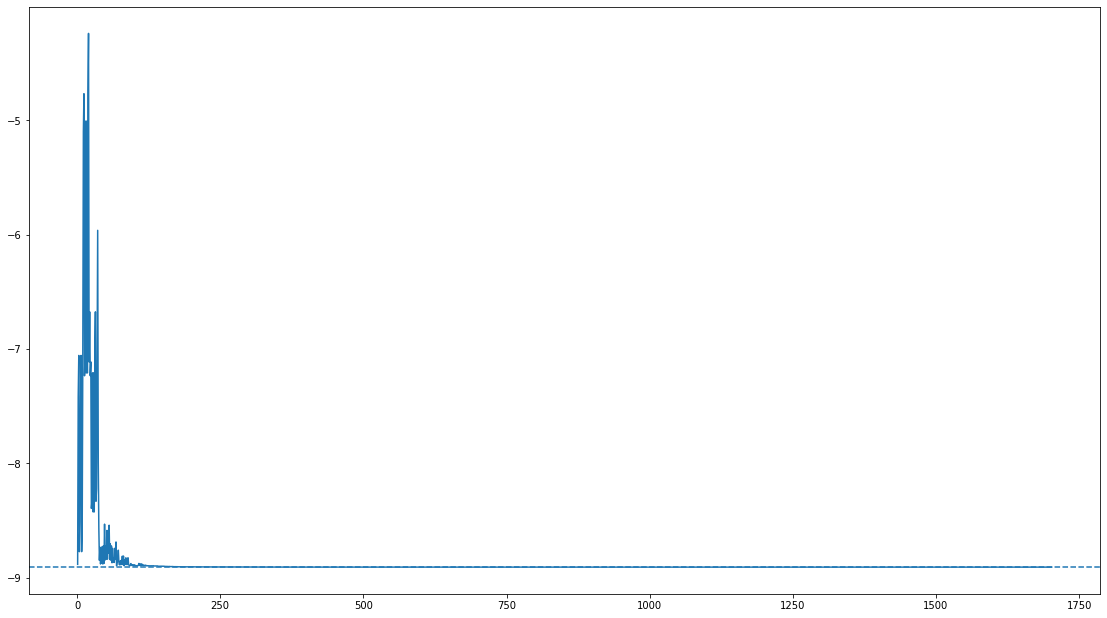

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')

In [23]:
from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# we choose a fixed small displacement

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
    
algorithm = VQE(
    ansatz,
    optimizer=optimizer,
    quantum_instance=state_sim,
    callback=callback,
    initial_point=initial_point
)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1760,
    'eigenstate': array([-2.31173929e-17+3.42219360e-18j,  1.39125837e-16-2.36470222e-15j,
       -1.51623017e-17-4.73380541e-17j, -8.58182853e-17-2.11145335e-17j,
        9.56000924e-17+1.11275069e-18j, -8.89085831e-17-6.80087965e-17j,
        7.49836222e-18+3.75992770e-17j,  9.32859109e-18+6.32409699e-17j,
        6.26942978e-16-8.72532243e-16j,  9.88007763e-01-2.21345880e-15j,
       -2.22572664e-04-2.25702195e-18j,  3.61983965e-02-1.00203048e-15j,
        8.28049505e-04-3.87408003e-17j, -1.05139191e-15-1.08047102e-16j,
        5.14889618e-04+2.71259952e-17j,  3.32875966e-03+7.19137849e-17j,
       -9.30754552e-17+2.65925942e-18j, -2.71242995e-04+2.27557611e-17j,
       -3.77589050e-03+1.20255164e-16j,  2.01724024e-04+1.09064628e-16j,
        1.69941451e-05+6.50029682e-17j,  1.90067985e-17-8.20079071e-17j,
        1.22313212e-04-1.89962668e-17j,  9.37393787e-05+8.16430528e-18j,
        5.19859856e-17-1.02668158e-

In [24]:
# Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
# Unroller transpile our circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

# if ansatz_type == "TwoLocal":
result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': qubit_converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

,optimizer,ansatz,# of qubits,error (mHa),pass,score,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions
0,COBYLA,UCCSD,8,0.010256,True,1864,34,None,None,None,None


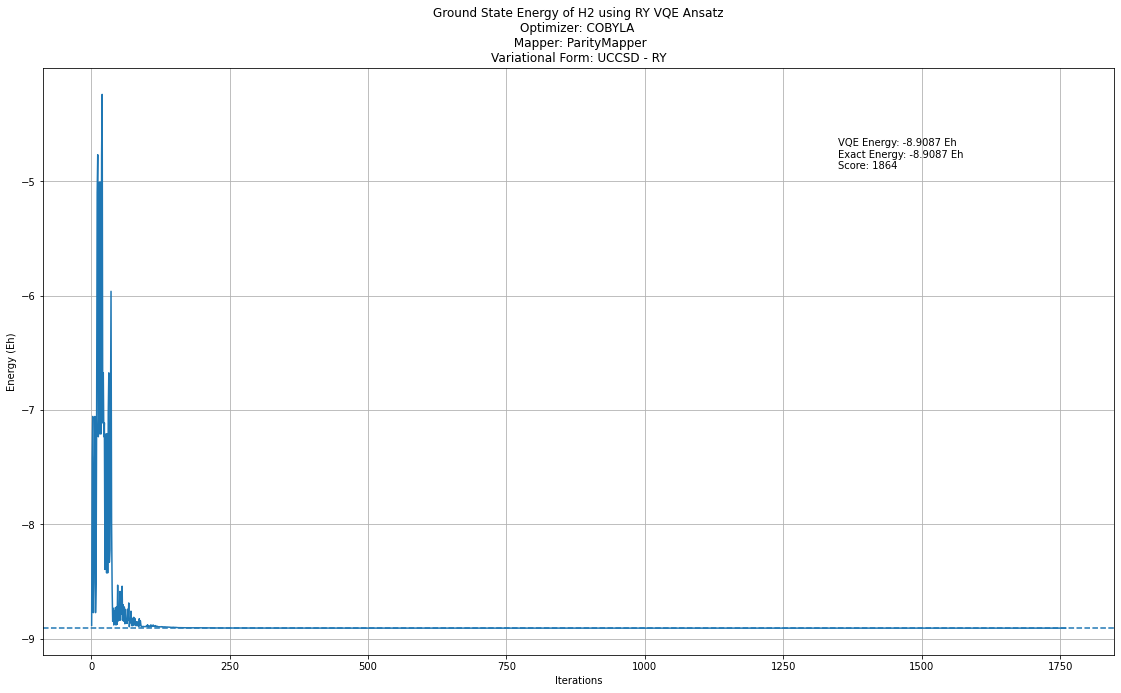

In [25]:
# Plotting the results

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))

# ax.set_facecolor("#293952")
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Eh)')
ax.grid()

fig.text(0.7, 0.75, f'VQE Energy: {result.optimal_value:.4f} Eh\nExact Energy: {exact_energy:.4f} Eh\nScore: {score:.0f}')

plt.title(f"Ground State Energy of H2 using RY VQE Ansatz\nOptimizer: {result_dict['optimizer']} \n Mapper: {result_dict['mapping']}\nVariational Form: {result_dict['ansatz']} - RY")

ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')

fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
# fig.savefig(fig_title, dpi=300)


# Displaying and saving the data

import pandas as pd

result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', 'error (mHa)', 'pass', 'score','# of parameters','rotation blocks', 'entanglement_blocks',

    'entanglement', 'repetitions']]
